### <b>Importing needed libaries<b>

In [1]:
from ipywidgets import FloatProgress
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from copy import copy
import re
import math
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from etl import load_files_into_df, preprocess_text, layer_normalize

### <b>Loading `distiluse-base-multilingual-cased-v1` model<b>

In [4]:
# model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [5]:
SEED = 42
random.seed(SEED)

### <b>Load dataset<b>

In [6]:
filename = 'preprocessed_with_categories.csv'
df = pd.read_csv(
    os.path.join('..', 'data-preprocessed', filename))

### <b>Clear contents - prepare for modeling<b>

In [7]:
EXT = '.csv'
EMPTY_CONTENTS_SUFFIX = '_EMPTY_CONTENTS'

In [8]:
empty_contents_indexes = np.where(df['content'].apply(lambda x: not isinstance(x, str)))[0]
df.iloc[empty_contents_indexes].to_csv(
    path_or_buf=f'{os.path.split(filename)[0]}{EMPTY_CONTENTS_SUFFIX}{EXT}',
    index=True)
df.drop(index=empty_contents_indexes, inplace=True)

In [9]:
len(df)

3472

In [10]:
sentences = list(map(preprocess_text, df['content']))

### <b>Create sentence embeddings<b>

In [11]:
sentence_embeddings = model.encode(
    # [s for s in sentences if len(s.split(' ')) > 15],
    sentences=sentences,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

### <b>Apply dimensionality reduction - UMAP<b>

In [12]:
import umap.umap_ as UMAP

c:\Users\Piotr\.conda\envs\nawros-torch\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Piotr\.conda\envs\nawros-torch\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Piotr\.conda\envs\nawros-torch\lib\site-packages\umap\distances.py:1086: 

In [13]:
clusterable_embeddings = UMAP.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=5,
    random_state=42,
    metric='cosine'
).fit_transform(sentence_embeddings)

In [43]:
clust_test = UMAP.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=5,
    random_state=42,
    metric='cosine'
).fit_transform(sentence_embeddings[result.loc[result['labels'].isin([-1])].index, :])

In [14]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          min_samples=5,
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(clusterable_embeddings)

In [45]:
cluster2 = hdbscan.HDBSCAN(min_cluster_size=15,
                          min_samples=10,
                          metric='euclidean',                      
                          cluster_selection_method='leaf').fit(clust_test)

In [15]:
sh_score = silhouette_score(
    clusterable_embeddings[np.where(cluster.labels_ != -1)[0], :], 
    cluster.labels_[np.where(cluster.labels_ != -1)[0]])

In [16]:
sh_score

0.59366006

In [17]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = UMAP.UMAP(
    n_neighbors=15, 
    n_components=2, 
    min_dist=0.0, 
    metric='cosine').fit_transform(sentence_embeddings)

In [18]:
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

In [19]:
len(set(result['labels']))

63

In [20]:
result['labels'].value_counts()

labels
-1     1426
 12     135
 32     100
 61      93
 30      75
       ... 
 46      18
 1       17
 36      17
 4       17
 53      16
Name: count, Length: 63, dtype: int64

In [21]:
result

,x,y,labels
0,-5.163079,1.916635,12
1,-2.328828,0.825254,60
2,-0.093391,5.519411,44
3,-4.140105,3.196755,0
4,-1.203087,1.221754,-1
...,...,...,...
3467,1.860316,2.264961,32
3468,-2.263594,-1.190414,27
3469,-2.292225,-1.180566,27
3470,2.374043,3.500449,25


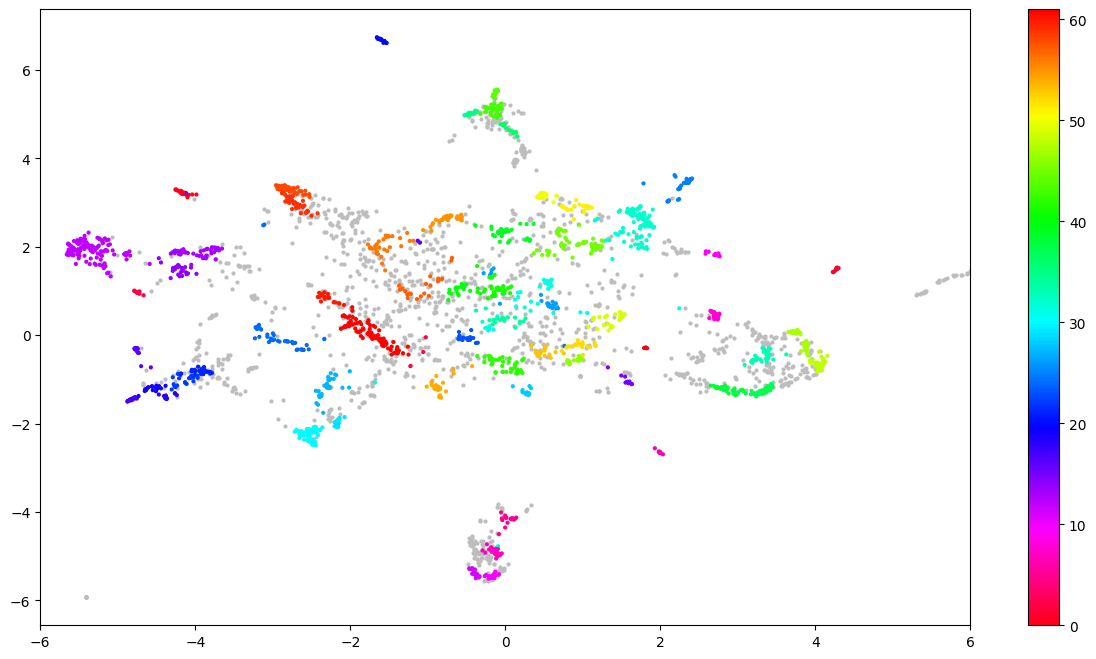

In [25]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 8))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=4)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=4, cmap='hsv_r')
ax.set_xlim(-6, 6)
plt.colorbar()
plt.show()

In [133]:
indexes_to_plot = df.loc[df['True_category'] != '<NO_VALUE>'].index

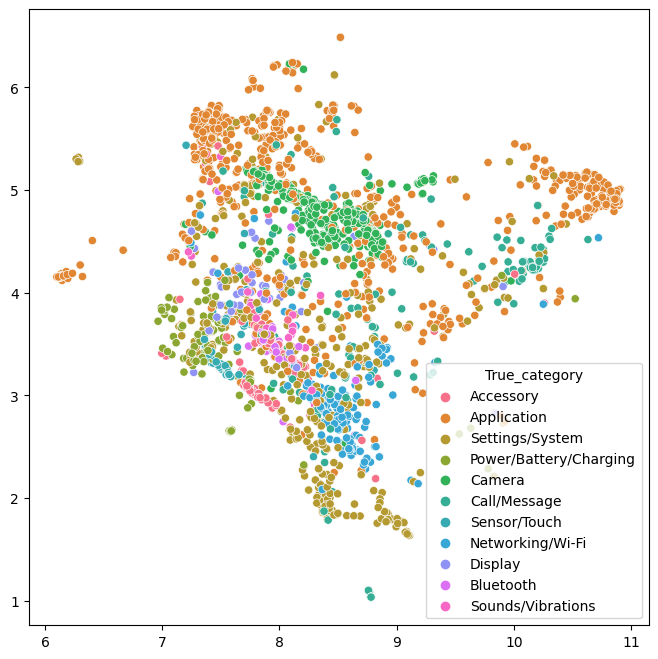

In [96]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x=clusterable_embeddings[indexes_to_plot, 0], 
    y=clusterable_embeddings[indexes_to_plot, 1],
    hue=df.loc[df['True_category'] != '<NO_VALUE>']['True_category'],
    ax=ax)
plt.show()

### <b>Normalize output

In [23]:
normalized_embeddings = np.apply_along_axis(
    layer_normalize, 
    axis=-1, 
    arr=clusterable_embeddings)

### **At first I will try with simple `K-Means clustering`**

In [85]:
wss_scores = []

for k in range(12, 18):

    kmeans = KMeans(
        n_clusters=k, 
        n_init=100, 
        random_state=SEED,
        max_iter=2000)
    
    kmeans.fit(clusterable_embeddings)    
    wss_scores.append(kmeans.inertia_)
    
    sh_score = silhouette_score(
        clusterable_embeddings, 
        kmeans.labels_)

    print(f"Silhouette score for k = {k}: {sh_score}")

Silhouette score for k = 12: 0.429904580116272
Silhouette score for k = 13: 0.4430448114871979
Silhouette score for k = 14: 0.4481312334537506
Silhouette score for k = 15: 0.4547732174396515
Silhouette score for k = 16: 0.44982075691223145
Silhouette score for k = 17: 0.45038411021232605


In [86]:
kmeans = KMeans(
    n_clusters=17, 
    n_init=100, 
    random_state=SEED,
    max_iter=4000)
    
kmeans.fit(clusterable_embeddings)

KMeans(max_iter=4000, n_clusters=17, n_init=100, random_state=42)

In [87]:
sh_score = silhouette_score(
        clusterable_embeddings, 
        kmeans.labels_)
sh_score

0.4503841

In [26]:
df['Predicted'] = result['labels'].copy()

In [29]:
list(df.loc[df['Predicted'] == 30]['content'])

['Ever since the last software update my phone battery is draining very fast and for no reason.  Its draing about 33%+ at night when not being used and all apps closed. Samsung A50',
 'Hoje battery draining constantly',
 "My battery does not charge up while I'm using the tablet,  I drops down,  why?",
 "Battery drains quick when I use camera. Friends have other phones with Snapchat used constantly and their phone last longer and I don't use Snapchat",
 "I bought a new S22 phone, and even with the power saving mode constantly enabled, I often can't get a full day out of a charge. My previous phone, an A12 had a much better battery.  I'm not happy with the phone and would like it checked out to see what's wrong with it, or get it replaced.  Thanks for your help.",
 'Używam telefonu dłużej Niż 14 dni i wciąż mam ten sam problem. Bateria szybko się rozładowuje.  Codziennie musze ładowac choc nie Używam czesto',
 'Bardzo częste grzanie się telefonu. Szybkie rozładowanie baterii. Dosyć częst

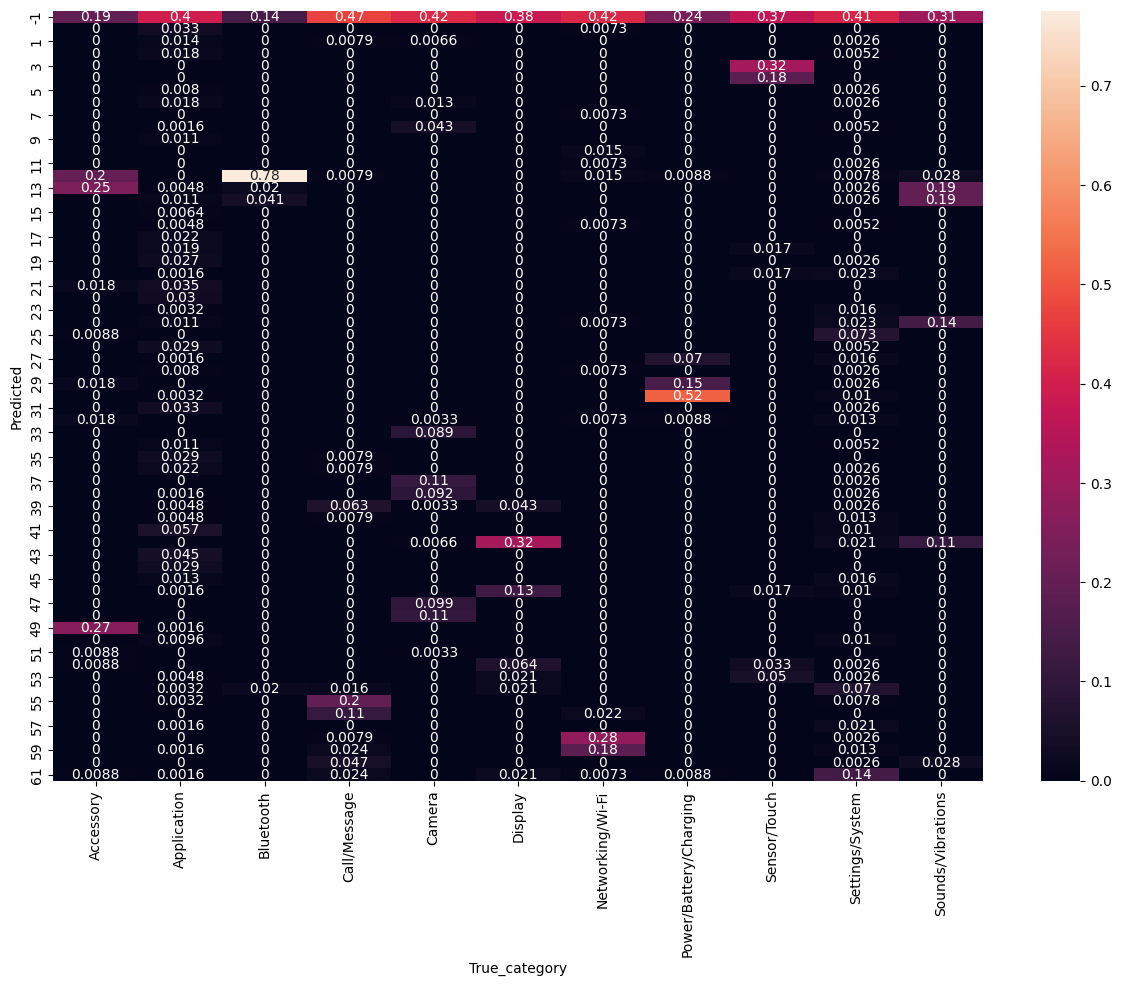

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.crosstab(
    index=df.loc[df['True_category'] != '<NO_VALUE>']['Predicted'], 
    columns=df.loc[df['True_category'] != '<NO_VALUE>']['True_category'],
    normalize='columns'), 
    annot=True,
    ax=ax)

plt.show()